# Fine Tuning Notibert for Sentiment Analysis

## Introduccion: 

Este notebook parte de una copia del tutorial de fine tuning a Roberta para Sentiment Analysis de la pagina de [huggingface](https://huggingface.co/docs/transformers/model_doc/roberta#resources). Es por esto que puede ocurrir que exista algun comentario o texto incorrecto (resultado de las modificaciones que hicimos nosotros, adaptando a nuestro dataset y modelo).
Los principales cambios se encuentran en:
- manejo del dataset: usamos dataset_final.csv
- Variables referenciando al modelo usado y prefijos para el nombre final: MODEL_PATH y STEPS
- Variables relacionadas al modelo: MAX_LENGTH, BATCH_SIZE
- Dimensiones del modelo de entrenamiento
``` python
  self.classifier = torch.nn.Linear(768, 3)
```
- Informacion adicional al entrenamiento y validacion: grafica de loss y matriz de confusion.



### Introduction

In this tutorial I will be fine tuning a roberta model for the **Sentiment Analysis** problem. 

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data: 
	 - I will be using the dataset available at [Kaggle Competition](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only)
	 - I will be referring only to the first csv file from the data dump: `train.tsv`

 - Language Model Used:
	 - The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.
	 - [Blog-Post](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/)
	 - [Research Paper](https://arxiv.org/pdf/1907.11692)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/roberta.html)


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup 

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* tqdm
* sklearn
* Robert Model and Tokenizer

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU. 

In [1]:
! ls

dataset_final.csv
sentiment_analysis_using_notibert-600K-Copy1.ipynb
sentiment_analysis_using_notibert-600K.ipynb
sentiment_analysis_using_notibert.ipynb
sentyment_model
sentyment_model_600k_12_epochs_20221129-0054


In [2]:
# !pip install transformers==3.0.2
!pip freeze | grep transformers
! conda env list

transformers @ git+https://github.com/huggingface/transformers@4fb34de99e800689862f80cd618e6468fcb7b28b
# conda environments:
#
base                  *  /clusteruy/home/gonzalo.marco.mohotse/miniconda3
env_prueba               /clusteruy/home/gonzalo.marco.mohotse/miniconda3/envs/env_prueba
optuna_xgb               /clusteruy/home/gonzalo.marco.mohotse/miniconda3/envs/optuna_xgb



In [3]:
!nvidia-smi 

Mon Dec 12 20:37:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:37:00.0 Off |                    0 |
| N/A   56C    P0    36W / 250W |      0MiB / 12288MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
# import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

import time

In [5]:
STEPS = '600k'
MODEL_PATH = '/clusteruy/home03/fing-pln-llm/models/modelo_notibert/backup_models/20221127_out_backup_600k_steps/checkpoint-600000'
MODEL_PATH

'/clusteruy/home03/fing-pln-llm/models/modelo_notibert/backup_models/20221127_out_backup_600k_steps/checkpoint-600000'

In [6]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
train = pd.read_csv('dataset_final.csv')

In [8]:
train.shape

(2199, 2)

In [9]:
train.head()

,label,text
0,1,"Según Batlle , esas palabras "" son palabras mu..."
1,1,Batlle también defendió la recompra
2,0,anuncio de Batlle sobre juicio a ex socios de ...
3,1,""" Siento una enorme alegría y regocijo "" , dij..."
4,2,""" Conversaciones entre presidentes son en seri..."


In [10]:
train.columns = ['Sentiment', 'Phrase']
train = train[['Phrase', 'Sentiment']]
train

,Phrase,Sentiment
0,"Según Batlle , esas palabras "" son palabras mu...",1
1,Batlle también defendió la recompra,1
2,anuncio de Batlle sobre juicio a ex socios de ...,0
3,""" Siento una enorme alegría y regocijo "" , dij...",1
4,""" Conversaciones entre presidentes son en seri...",2
...,...,...
2194,Batlle dijo que el ministro Irureta opinó sin ...,1
2195,""" Esta es la vigencia de la democracia y de su...",1
2196,"Batlle consideró que la próxima será "" una bue...",1
2197,Batlle declaró su satisfacción por la forma en...,1


In [11]:
train['Sentiment'].unique()

array([1, 0, 2])

In [12]:
train.describe()

,Sentiment
count,2199.000000
mean,0.903593
std,0.787632
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [13]:
new_df = train[['Phrase', 'Sentiment']]
new_df.shape

(2199, 2)

<a id='section03'></a>
### Preparing the Dataset and Dataloader

I will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. I will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing. 
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *SentimentData* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the Roberta model for training. 
- I am using the Roberta tokenizer to tokenize the data in the `TITLE` column of the dataframe. 
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/roberta.html#robertatokenizer)
- `target` is the encoded category on the news headline. 
- The *SentimentData* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [14]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 4
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained(MODEL_PATH, truncation=True, do_lower_case=True)

In [15]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Phrase
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (2199, 2)
TRAIN Dataset: (1759, 2)
TEST Dataset: (440, 2)


In [17]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `RobertaClass`. 
 - This network will have the Roberta Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs. 
 - The data will be fed to the Roberta Language model as defined in the dataset. 
 - Final layer outputs is what will be compared to the `Sentiment category` to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output. 
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [18]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained(MODEL_PATH)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [19]:
model = RobertaClass()
model.to(device)

Some weights of the model checkpoint at /clusteruy/home03/fing-pln-llm/models/modelo_notibert/backup_models/20221127_out_backup_600k_steps/checkpoint-600000 were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /clusteruy/home03/fing-pln-llm/models/modelo_notibert/backup_models/20221127_out_backup_600k_steps/checkpoint-600000 and are newly initializ

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process. 

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network. 

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.


In [20]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [21]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [22]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    # agregar aca tr_loss_history = [], tr_loss_steps e ir agregando en la iteracion
    tr_loss_history = []
    tr_loss_steps = []
    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        tr_loss_history.append(loss.item())
        
        
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    
    return tr_loss_history

In [23]:
tr_loss_history = []

train_t1 = time.time()
EPOCHS = 17
for epoch in range(EPOCHS):
    tr_loss_history += train(epoch)
train_t2 = time.time()
print("Total training time spent: {:.4f}".format((train_t2-train_t1)/60))


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/clusteruy/home/gonzalo.marco.mohotse/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.0534312725067139
Training Accuracy per 5000 steps: 40.625


55it [00:22,  2.39it/s]


The Total Accuracy for Epoch 0: 46.219442865264355
Training Loss Epoch: 1.039289723743092
Training Accuracy Epoch: 46.219442865264355


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.8833935856819153
Training Accuracy per 5000 steps: 65.625


55it [00:21,  2.51it/s]


The Total Accuracy for Epoch 1: 66.68561682774303
Training Loss Epoch: 0.830772573297674
Training Accuracy Epoch: 66.68561682774303


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.844031810760498
Training Accuracy per 5000 steps: 75.0


55it [00:22,  2.43it/s]


The Total Accuracy for Epoch 2: 76.06594656054577
Training Loss Epoch: 0.6207891811024059
Training Accuracy Epoch: 76.06594656054577


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.3331325650215149
Training Accuracy per 5000 steps: 90.625


55it [00:34,  1.58it/s]


The Total Accuracy for Epoch 3: 83.05855599772597
Training Loss Epoch: 0.4500870563767173
Training Accuracy Epoch: 83.05855599772597


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.19067436456680298
Training Accuracy per 5000 steps: 93.75


55it [00:52,  1.06it/s]


The Total Accuracy for Epoch 4: 90.90392268334281
Training Loss Epoch: 0.287444317611781
Training Accuracy Epoch: 90.90392268334281


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.07667018473148346
Training Accuracy per 5000 steps: 100.0


55it [00:57,  1.04s/it]


The Total Accuracy for Epoch 5: 94.88345650938032
Training Loss Epoch: 0.17223016700961374
Training Accuracy Epoch: 94.88345650938032


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.19301970303058624
Training Accuracy per 5000 steps: 96.875


55it [00:59,  1.08s/it]


The Total Accuracy for Epoch 6: 97.55542922114837
Training Loss Epoch: 0.09511955045163631
Training Accuracy Epoch: 97.55542922114837


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.06054069846868515
Training Accuracy per 5000 steps: 100.0


55it [01:05,  1.18s/it]


The Total Accuracy for Epoch 7: 98.91984081864696
Training Loss Epoch: 0.0492607062513178
Training Accuracy Epoch: 98.91984081864696


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.07712670415639877
Training Accuracy per 5000 steps: 96.875


55it [01:03,  1.15s/it]


The Total Accuracy for Epoch 8: 99.09039226833428
Training Loss Epoch: 0.03902091294188391
Training Accuracy Epoch: 99.09039226833428


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.023922741413116455
Training Accuracy per 5000 steps: 100.0


55it [01:07,  1.23s/it]


The Total Accuracy for Epoch 9: 99.65889710062535
Training Loss Epoch: 0.02469467151571404
Training Accuracy Epoch: 99.65889710062535


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.007988880388438702
Training Accuracy per 5000 steps: 100.0


55it [01:01,  1.12s/it]


The Total Accuracy for Epoch 10: 99.43149516770893
Training Loss Epoch: 0.020403541760011152
Training Accuracy Epoch: 99.43149516770893


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.004495729226619005
Training Accuracy per 5000 steps: 100.0


55it [01:09,  1.26s/it]


The Total Accuracy for Epoch 11: 99.82944855031268
Training Loss Epoch: 0.011614925418557092
Training Accuracy Epoch: 99.82944855031268


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.009809850715100765
Training Accuracy per 5000 steps: 100.0


55it [01:09,  1.26s/it]


The Total Accuracy for Epoch 12: 99.71574758385447
Training Loss Epoch: 0.015244680177420377
Training Accuracy Epoch: 99.71574758385447


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.0044138203375041485
Training Accuracy per 5000 steps: 100.0


55it [01:08,  1.24s/it]


The Total Accuracy for Epoch 13: 99.48834565093803
Training Loss Epoch: 0.021440652893348174
Training Accuracy Epoch: 99.48834565093803


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.004160341806709766
Training Accuracy per 5000 steps: 100.0


55it [01:10,  1.27s/it]


The Total Accuracy for Epoch 14: 99.37464468447982
Training Loss Epoch: 0.01701073516583578
Training Accuracy Epoch: 99.37464468447982


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.002372103277593851
Training Accuracy per 5000 steps: 100.0


55it [01:07,  1.22s/it]


The Total Accuracy for Epoch 15: 99.77259806708356
Training Loss Epoch: 0.012011595233343542
Training Accuracy Epoch: 99.77259806708356


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.0057211145758628845
Training Accuracy per 5000 steps: 100.0


55it [01:09,  1.27s/it]

The Total Accuracy for Epoch 16: 99.48834565093803
Training Loss Epoch: 0.016685474517924542
Training Accuracy Epoch: 99.48834565093803
Total training time spent: 15.7124


In [27]:
! pip install matplotlib

Text(0, 0.5, 'Loss')

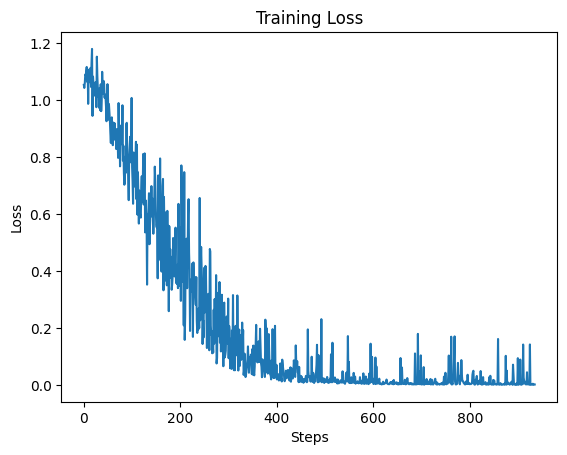

In [24]:
from matplotlib.pylab import plt
from numpy import arange
 
# Generate a sequence of integers to represent the epoch numbers

steps = range(0, len(tr_loss_history))
 
# Plot and label the training and validation loss values
plt.plot(steps, tr_loss_history, label='Training Loss')
 
# Add in a title and axes labels
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
 

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the 20% of `train.tsv` which was seperated during the Dataset creation stage. 
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As you can see the model is predicting the correct category of a given sample to a 69.47% accuracy which can further be improved by training more.

In [25]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [26]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0it [00:00, ?it/s]/clusteruy/home/gonzalo.marco.mohotse/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
6it [00:00, 28.65it/s]

Validation Loss per 100 steps: 1.8970322608947754
Validation Accuracy per 100 steps: 75.0


110it [00:07, 15.37it/s]

Validation Loss Epoch: 1.6966576796273742
Validation Accuracy Epoch: 68.86363636363636
Accuracy on test data = 68.86%


<a id='section06-B'></a>
#### More information

In [28]:

test_params2 = {'batch_size': len(testing_set),
                'shuffle': True,
                'num_workers': 0
                }

testing_loader2 = DataLoader(testing_set, **test_params2)


model.eval()
with torch.no_grad():
    for _, data in tqdm(enumerate(testing_loader2, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(ids, mask, token_type_ids).squeeze()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        
# segun proceso de armado de datasets: {'Neg':0, 'Pos':1, 'Neu':2}
target_names = ['Neg', 'Pos', 'Neu']

y_test = targets.cpu().detach().numpy()
y_pred = big_idx.cpu().detach().numpy()



1it [00:00,  4.83it/s]


              precision    recall  f1-score   support

         Neg       0.65      0.83      0.73       155
         Pos       0.77      0.72      0.75       161
         Neu       0.62      0.47      0.53       124

    accuracy                           0.69       440
   macro avg       0.68      0.67      0.67       440
weighted avg       0.69      0.69      0.68       440



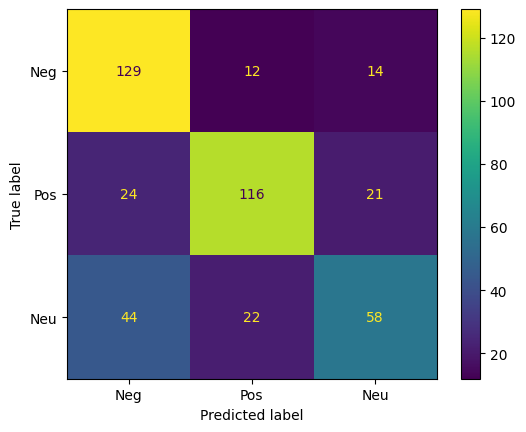

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model. 

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

In [30]:
import os
from datetime import datetime

timestamp = '{:%Y%m%d-%H%M}'.format(datetime.now())
folder_path = f'sentyment_model_{STEPS}_{EPOCHS}_epochs_{timestamp}'
os.makedirs(folder_path)

output_model_file = f'{folder_path}/notibert_sentiment.bin'
output_vocab_file = f'{folder_path}/'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
